In [1]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [2]:
import torch
import pickle
from dataloaders import get_data_loaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_gLRI2d import Bipartite_Attention as Model
import numpy as np
import matplotlib.colors as colors
from sklearn.cluster import KMeans, OPTICS
from scipy.stats import iqr
from numpy.linalg import inv

In [3]:
# α=0.3
config_file_path = 'train_results/biatt-glri-2d/experiment_2023-05-18_00:42:18/config.pkl'
#config_file_path = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [4]:
config['lri']['sigma']

1

In [5]:
config['lri']['beta']

0.0016204047673817822

In [6]:
dconfig = config['data']
dconfig['use_trigger'] = True
dconfig['use_nontrigger'] = False
#dconfig['use_center'] = False
train_data, val_data, test_data = get_data_loaders(**dconfig)

In [7]:
DEVICE = 'cuda:0'
# α=0.3
checkpoint_file = 'train_results/biatt-glri-2d/experiment_2023-05-18_00:42:18/checkpoints/model_checkpoint_013.pth.tar'
#checkpoint_file = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/checkpoints/model_checkpoint_011.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

Bipartite_Attention(
  (interpreter): Bipartite_Attention(
    (_layers): ModuleList(
      (0): Bipartite_Layers(
        (enc): ModuleList(
          (0): Masked_SAB(
            (mab): Masked_MAB(
              (fc_q): Linear(in_features=32, out_features=128, bias=True)
              (fc_k): Linear(in_features=32, out_features=128, bias=True)
              (fc_v): Linear(in_features=32, out_features=128, bias=True)
              (fc_o): Linear(in_features=128, out_features=128, bias=True)
              (ln0): Masked_LayerNorm(
                (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              )
              (ln1): Masked_LayerNorm(
                (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              )
            )
          )
          (1): Masked_SAB(
            (mab): Masked_MAB(
              (fc_q): Linear(in_features=128, out_features=128, bias=True)
              (fc_k): Linear(in_features=128, out_features=128, bias=True)
       

In [8]:
def get_approximate_radii(track_vector):
    tracks_info = track_vector[:, :15]
    good_hits = np.any(tracks_info.reshape(tracks_info.shape[0], 5, 3) != 0, axis=-1)
    n_hits = np.sum(good_hits, axis=-1)
    x_indices = [3*j for j in range(5)]
    y_indices = [3*j+1 for j in range(5)]
    r = np.zeros((tracks_info.shape[0], 1))
    centers = np.zeros((tracks_info.shape[0], 2))
    for n_hit in range(3, 5 + 1):
        complete_tracks = tracks_info[n_hits == n_hit]
        hit_indices = good_hits[n_hits == n_hit]
        if complete_tracks.shape[0] == 0:
            continue

        A = np.ones((complete_tracks.shape[0], n_hit, 3))
        x_values = complete_tracks[:, x_indices]
        x_values = x_values[hit_indices].reshape(complete_tracks.shape[0], n_hit)

        y_values = complete_tracks[:, y_indices]
        y_values = y_values[hit_indices].reshape(complete_tracks.shape[0], n_hit)
        A[:, :, 0] = x_values
        A[:, :, 1] = y_values

        y = - x_values**2 - y_values**2
        y = y.reshape((y.shape[0], y.shape[1], 1))
        AT = np.transpose(A, axes=(0, 2, 1))
        c = matmul_3D(matmul_3D(inv(matmul_3D(AT, A)), AT), y)
        r[n_hits == n_hit] == 1
        r[n_hits == n_hit] = np.sqrt(c[:, 0]**2 + c[:, 1]**2 - 4*c[:, 2])/200
        centers[n_hits == n_hit] = np.concatenate([-c[:, 0]/2, -c[:, 1]/2], axis=-1)
    #test = get_approximate_radius(tracks_info, n_hits == 5)
    #assert np.allclose(test, r[n_hits == 5])

    return r, centers

def matmul_3D(A, B):
    return np.einsum('lij,ljk->lik', A, B)

def decode(n):
    if n == 0b00:
        return 'tt'
    elif n == 0b01:
        return 'pt'
    elif n == 0b10:
        return 'tp'
    else:
        return 'tt'
    vectors = ['t', 'p']
    if n == 0:
        return '0'
    nums = []
    while n:
        n, r = divmod(n, 2)
        nums.append(vectors[r])
    return ''.join(nums)

def calculate_n_bins(values):
    h = 2*iqr(values)/(len(values)**(1/3))
    return int(np.round((np.max(values)-np.min(values))/h))


def zipdict(d):
    keys = tuple(d.keys())
    for v in zip(*[d[key] for key in keys]):
        yield dict(zip(keys, v))
    
    
def dict_freeze(d):
    if isinstance(d, defaultdict):
        d = {k: dict_freeze(v) for k, v in d.items()}
    return d

In [9]:
events = defaultdict(list)

In [10]:
N_BATCHES = 100
for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1
        
    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)
    
    _, pred_sigmas, valid_hits = model(track_vector, mask, finetune_epoch=True)
    for i, (track, momentum, origin_vertex, n_tracks) in enumerate(zip(batch.track_vector, batch.momentums, batch.origin_vertices, batch.n_tracks)):
        r, c = get_approximate_radii(track[:n_tracks].detach().cpu().numpy())
        events['hits'].append(track[:n_tracks, :15].reshape(n_tracks, 5, 3).detach().cpu().numpy())
        x = events['hits'][-1][..., 0]
        y = events['hits'][-1][..., 1]
        c_x = c[..., 0]
        c_y = c[..., 1]
        e_p = np.stack([(x - np.expand_dims(c_x, -1)), (y - np.expand_dims(c_y, -1)), np.zeros(y.shape)], axis=-1)
        events['e_p'].append(e_p[..., :2]/np.expand_dims(np.linalg.norm(e_p[..., :2], axis=-1), -1))
        z = np.array([0, 0, 1]).reshape(1, 1, -1)
        e_t = np.cross(e_p, z)[..., :2]
        events['e_t'].append(e_t/np.expand_dims(np.linalg.norm(e_t, axis=-1), -1))
        events['trigger_mask'].append(is_trigger_track[i][:n_tracks].unsqueeze(-1).repeat(1, 5).detach().cpu().numpy())
        events['good_hits_mask'].append(valid_hits[i][:n_tracks].detach().cpu().numpy())
        events['sigmas'].append(pred_sigmas[i][:n_tracks].detach().cpu().numpy())
events = dict_freeze(events)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_982015/801600417.py:21: RuntimeWarning: invalid value encountered in divide
  events['e_p'].append(e_p[..., :2]/np.expand_dims(np.linalg.norm(e_p[..., :2], axis=-1), -1))
/tmp/ipykernel_982015/801600417.py:24: RuntimeWarning: invalid value encountered in divide
  events['e_t'].append(e_t/np.expand_dims(np.linalg.norm(e_t, axis=-1), -1))


# Symmetricity Clusters

In [11]:
hits = defaultdict(lambda: defaultdict(list))

for event in zipdict(events):
    event['n_hits'] = np.expand_dims(np.sum(event['good_hits_mask'], axis=-1), -1).repeat(5, -1).reshape(-1)
    event['good_hits_mask'] = event['good_hits_mask'].reshape(-1)
    event['trigger_mask'] = event['trigger_mask'].reshape(-1)
    masks = {'all': event['good_hits_mask'], 
             'trigger': event['good_hits_mask'] * event['trigger_mask'], 
             'nontrigger': event['good_hits_mask'] * ~event['trigger_mask']
            }

    basis = np.stack([event['e_t'], event['e_p']], axis=-1) # Stack them in the column.
    basis = basis.reshape(-1, 2, 2)
    for name, mask in masks.items():
        sigmas = event['sigmas'].reshape(-1, 2, 2)[mask]
        eigenvalues, eigenvectors = np.linalg.eig(sigmas)
        order = np.argsort(eigenvalues, axis=-1)
        eigenvectors = np.take_along_axis(eigenvectors, np.expand_dims(order, 1), -1)
        eigenvalues = np.sort(eigenvalues, axis=-1)
        coefficients = np.einsum('hfb,hfe->heb', basis[mask], eigenvectors)
        hits[name]['coefficients'].extend(coefficients)
        hits[name]['eigenvectors'].extend(eigenvectors)
        hits[name]['eigenvalues'].extend(eigenvalues)
        hits[name]['symmetricity'].extend(np.prod(eigenvalues, axis=-1)/np.max(eigenvalues, axis=-1)**2)
        hits[name]['n_hits'].extend(event['n_hits'][mask])
        hits[name]['e_t'].extend(event['e_t'].reshape(-1, 2)[mask])
        hits[name]['e_p'].extend(event['e_p'].reshape(-1, 2)[mask])
        
for hit_type in hits.keys():
    for attribute in hits[hit_type].keys():
        hits[hit_type][attribute] = np.stack(hits[hit_type][attribute], axis=0)
hits = dict_freeze(hits)

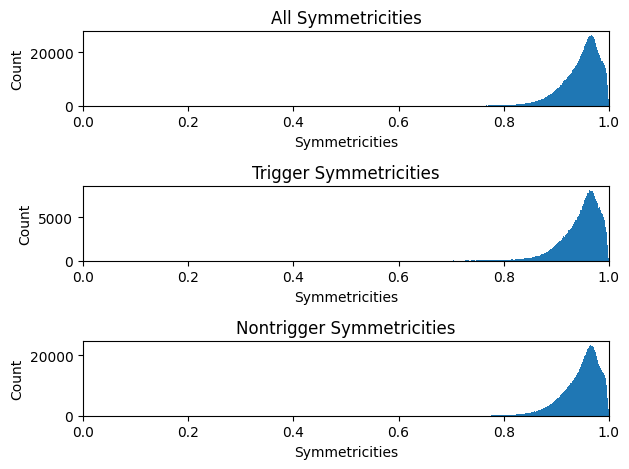

In [12]:
fig, axes = plt.subplots(len(hits), 1)
peaks_dict = {}
for axis, (key, attributes) in zip(axes, hits.items()):
    n_bins = calculate_n_bins(attributes['symmetricity'])
    counts, bins, _ = axis.hist(attributes['symmetricity'], bins=n_bins)
    axis.set_title(f'{key.capitalize()} Symmetricities')
    axis.set_xlabel('Symmetricities')
    axis.set_ylabel('Count')
    axis.set_xlim(0, 1)
    peaks_dict[key] = bins[np.argsort(counts)[-2:]]
fig.tight_layout()

In [13]:
clusters_dict = {}
for key, attributes in hits.items():
    symmetricity = attributes['symmetricity']
    peaks = peaks_dict[key]
    clusters_dict[key] = KMeans(n_clusters=len(peaks), init=np.sort(peaks).reshape(-1, 1), n_init=1).fit(symmetricity.reshape(-1, 1))

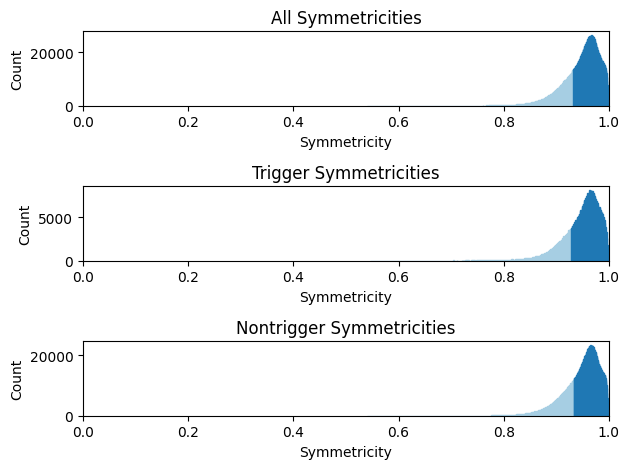

In [14]:
mode_ranges_dict = defaultdict(lambda: {})
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
fig, axes = plt.subplots(len(clusters_dict), 1)
for axis, (key, classifier) in zip(axes, clusters_dict.items()):
    symmetricities = hits[key]['symmetricity']
    n_bins = calculate_n_bins(symmetricities)
    _, bins, rectangles = axis.hist(symmetricities, bins=n_bins)
    bin_centers = np.mean(np.stack([bins[:-1], bins[1:]], axis=-1), axis=-1)
    bin_classes = classifier.predict(bin_centers.reshape(-1, 1).astype(np.float32))
    edge_classes = classifier.predict(bins.reshape(-1, 1).astype(np.float32))
    cluster_order = np.argsort(classifier.cluster_centers_.squeeze(1))
    for i in range(len(classifier.cluster_centers_)):
        mode_ranges_dict[key][i] = (np.min(bins[edge_classes == cluster_order[i]]), np.max(bins[edge_classes == cluster_order[i]]))
        
    for rectangle, bin_class in zip(rectangles, bin_classes):
        rectangle.set(color=colors[bin_class])
    axis.set_title(f'{key.capitalize()} Symmetricities')
    axis.set_xlabel('Symmetricity')
    axis.set_ylabel('Count')
    axis.set_xlim(0, 1)
fig.tight_layout()

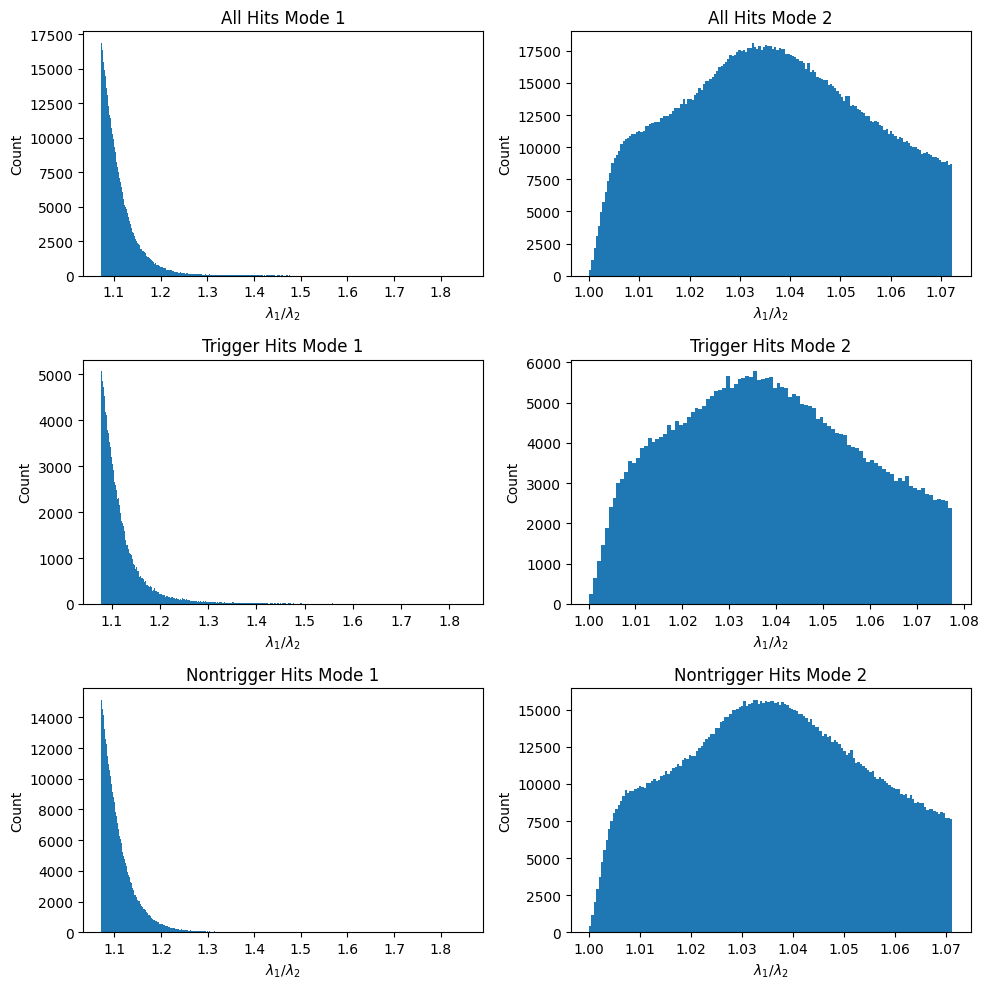

In [15]:
fig, axes = plt.subplots(len(mode_ranges_dict), 2, figsize=(10, 10))

for axes_row, (key, mode_ranges) in zip(axes, mode_ranges_dict.items()):
    for i, (axis, (b, e)) in enumerate(zip(axes_row, mode_ranges.values())):
        attributes = hits[key]
        symmetricities = attributes['symmetricity']
        mask = (symmetricities >= b) & (symmetricities < e)
        v = attributes['eigenvalues']
        l1, l2 = v[:, -1][mask], v[:, -2][mask]
        n_x_bins = calculate_n_bins(l1/l2)
        res = axis.hist(l1/l2, bins=n_x_bins)
        axis.set_title(f'{key.capitalize()} Hits Mode {i+1}')
        axis.set_xlabel('$\lambda_1/\lambda_2$')
        axis.set_ylabel('Count')
fig.tight_layout()

## Alignment

highest_base[0]=array([1, 0]) dist[0]=2 decode(dist[0])='tp'
highest_base[0]=array([0, 1]) dist[0]=1 decode(dist[0])='pt'
highest_base[0]=array([1, 0]) dist[0]=2 decode(dist[0])='tp'
highest_base[0]=array([0, 1]) dist[0]=1 decode(dist[0])='pt'
highest_base[0]=array([0, 1]) dist[0]=1 decode(dist[0])='pt'
highest_base[0]=array([1, 0]) dist[0]=2 decode(dist[0])='tp'


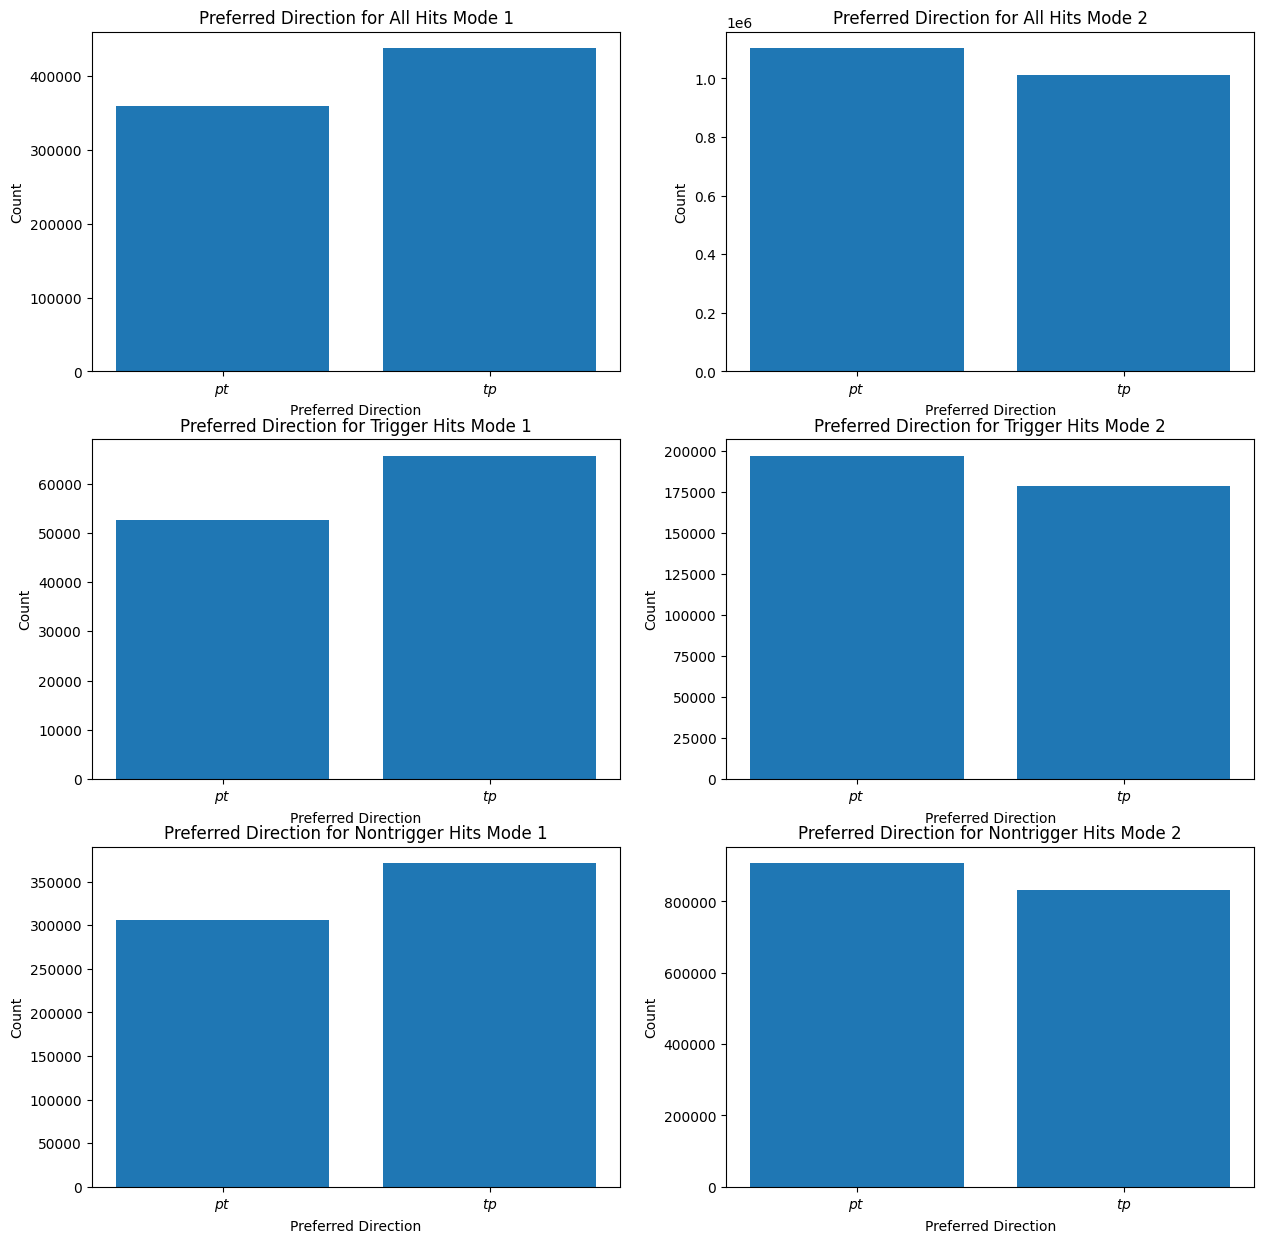

In [16]:
fig, axes = plt.subplots(len(mode_ranges_dict), 2, figsize=(15, 15))

for axes_row, (key, mode_ranges) in zip(axes, mode_ranges_dict.items()):
    for i, (axis, (b, e)) in enumerate(zip(axes_row, mode_ranges.values())):
        attributes = hits[key]
        symmetricities = attributes['symmetricity']
        mask = (symmetricities >= b) & (symmetricities < e)
        coefficients = attributes['coefficients'][mask]
        highest_base = np.argmax(np.abs(coefficients), axis=-1)
        dist = np.sum(highest_base * np.array([2**1, 2**0]), axis=-1)
        print(f'{highest_base[0]=} {dist[0]=} {decode(dist[0])=}')

        keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
        x = [f'${keys[k]}$' for k in sorted(keys.keys())]
        heights = [np.sum(dist == k) for k in sorted(keys.keys())]
        axis.bar(x, heights)
        #axis.set_yscale('log')
        axis.set_title(f'Preferred Direction for {key.capitalize()} Hits Mode {i+1}')
        axis.set_xlabel('Preferred Direction')
        axis.set_ylabel('Count')
                                       